In [1]:
import numpy as np, json, matplotlib, pycm, pandas as pd, seaborn as sn
from datetime import datetime
from conceptual_engineering_assistant import Concept, Entity, ConceptualEngineeringAssistant
from langchain.tools import WikipediaQueryRun
from langchain.utilities import WikipediaAPIWrapper
from langchain.document_loaders import WikipediaLoader

In [2]:
SAMPLE_SIZE = 40
females = np.random.choice(json.load(open('data/females-2023-03-15.json', 'r')), SAMPLE_SIZE)
males = np.random.choice(json.load(open('data/males-2023-03-15.json', 'r')), SAMPLE_SIZE)
non_binaries = np.random.choice(json.load(open('data/non-binaries-2023-03-15.json', 'r')), SAMPLE_SIZE)
trans_men = np.random.choice(json.load(open('data/trans-men-2023-03-15.json', 'r')), SAMPLE_SIZE)
trans_women = np.random.choice(json.load(open('data/trans-women-2023-03-15.json', 'r')), SAMPLE_SIZE)
sample = np.concatenate((females, trans_women, non_binaries, trans_men, males))

In [3]:
for entity in sample:
    entity["description"] = WikipediaLoader(query=entity["name"], load_max_docs=1).load()[0].page_content[:1200]

In [4]:
entities = pd.DataFrame.from_records(sample)
woman_conditions = [
    ((entities.gender == 'female') | (entities.gender == 'trans woman')),
    ((entities.gender == 'non-binary') | (entities.gender == 'male') | (entities.gender == 'trans man'))
]
woman_categories = ['true', 'false']
entities['woman'] = np.select(woman_conditions, woman_categories)
entities

,item,name,article,gender,description,woman
0,http://www.wikidata.org/entity/Q10864,Karen Bardsley,https://en.wikipedia.org/wiki/Karen_Bardsley,female,Karen Louise Bardsley (born 14 October 1984) i...,true
1,http://www.wikidata.org/entity/Q16372,Nalini Venkatasubramanian,https://en.wikipedia.org/wiki/Nalini_Venkatasu...,female,Nalini Venkatasubramanian is a Professor of Co...,true
2,http://www.wikidata.org/entity/Q65359,Renate Müller,https://en.wikipedia.org/wiki/Renate_M%C3%BCller,female,Renate Müller (26 April 1906 – 7 October 1937)...,true
3,http://www.wikidata.org/entity/Q13651,Ludmila Peterson,https://en.wikipedia.org/wiki/Ludmila_Peterson,female,"Ludmila Georgievna Peterson, (Russian: Людми́л...",true
4,http://www.wikidata.org/entity/Q53371,Dorothy Cheney,https://en.wikipedia.org/wiki/Dorothy_Cheney,female,"Dorothy ""Dodo"" May Sutton Bundy Cheney (Septem...",true
...,...,...,...,...,...,...
195,http://www.wikidata.org/entity/Q1929,Gaël Clichy,https://en.wikipedia.org/wiki/Ga%C3%ABl_Clichy,male,Gaël Dimitri Clichy (born 26 July 1985) is a F...,false
196,http://www.wikidata.org/entity/Q4119,Adam Carolla,https://en.wikipedia.org/wiki/Adam_Carolla,male,"Adam Carolla (born May 27, 1964) is an America...",false
197,http://www.wikidata.org/entity/Q377,Yanka Kupala,https://en.wikipedia.org/wiki/Yanka_Kupala,male,Yanka Kupala (Belarusian: Янка Купала; July 7 ...,false
198,http://www.wikidata.org/entity/Q11949,Dick Advocaat,https://en.wikipedia.org/wiki/Dick_Advocaat,male,Dirk Nicolaas Advocaat (Dutch pronunciation: [...,false


In [5]:
oed_woman = Concept("oed_woman", "woman", "An adult female human being. The counterpart of man (see man, n.¹ II.4.)")

In [6]:
haslanger_woman = Concept("haslanger_woman", "woman", """S is a woman iff (i) S is regularly and for the most part observed or imagined to have 
certain bodily features presumed to be evidence of a female’s biological role in reproduction; 
(ii) that S has these features marks S within the dominant ideology of S’s society as someone who 
ought to occupy certain kinds of social position that are in fact subordinate (and so motivates 
and justifies S’s occupying such a position); and (iii) the fact that S satisfies (I) and (ii) plays 
a role in S’s systematic subordination, that is, along some dimension, S’s social position is oppressive, 
and S’s satisfying (i) and (ii) plays a role in that dimension of subordination""")

In [7]:
homosaurus_woman = Concept("homosaurus_woman", "woman", """Adults who self-identify as women and understand their gender in terms of Western conceptions of 
womanness, femaleness, and/or femininity. The term has typically been defined as adult female humans, though not all women identify with 
the term "female" depending on the context in which it is used.""")

In [8]:
cea = ConceptualEngineeringAssistant()

In [9]:
oed_classifications = pd.DataFrame( 
    [ cea.classify_entity(oed_woman, Entity(entity["item"], entity["name"], entity["description"])) for entity in sample ], 
    columns = [ 'entity' , 'classification', 'rationale' ] 
    )
oed_classifications["classification"] = oed_classifications["classification"].str.lower()

Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised Timeout: Request timed out: HTTPSConnectionPool(host='api.openai.com', port=443): Read timed out. (read timeout=600).


In [10]:
oed_results = pd.concat([entities[["name", "gender", "woman"]], oed_classifications[["classification", "rationale"]]], axis=1)
results_styler = oed_results.style.set_properties(**{"text-align": "left", "overflow-wrap": "break-word"})
results_styler.set_table_styles([dict(selector='th', props=[('text-align', 'center')])]) 

,name,gender,woman,classification,rationale
0,Karen Bardsley,female,true,true,"Karen Bardsley is a woman because the definition of a woman is an adult female human being. The description of Karen Bardsley indicates that she is an adult, as she was born in 1984 and has had a career as a professional footballer. The description also refers to her using female pronouns, indicating that she is female. Therefore, according to the provided definition, Karen Bardsley is a woman."
1,Nalini Venkatasubramanian,female,true,true,"The definition provided for the concept of a woman is ""an adult female human being."" Nalini Venkatasubramanian fits this definition as she is an adult, as indicated by her professional status as a Professor of Computer Science and her achievements such as receiving a Ph.D. and working as a member of technical staff and software designer engineer for Hewlett-Packard. Furthermore, she is referred to with female pronouns ""she"" and ""her"" throughout the description, indicating that she is female. Therefore, based on the provided definition and the information given about Nalini Venkatasubramanian, it can be argued that she is a woman."
2,Renate Müller,female,true,true,"The assertion that Renate Müller is a woman can be supported by the information provided in the description. The definition of a woman is an adult female human being. Renate Müller is described as a female, as indicated by the use of female pronouns such as ""she"" and ""her"". Furthermore, she is described as an adult, as she had a career as a singer and actress, roles typically held by adults. Therefore, based on the definition and the information provided, Renate Müller can be classified as a woman."
3,Ludmila Peterson,female,true,true,"The text refers to Ludmila Peterson using female pronouns such as ""she"" and ""her"", indicating that she is an adult female human being. Therefore, according to the definition provided, Ludmila Peterson can be classified as a woman."
4,Dorothy Cheney,female,true,true,"Dorothy Cheney is a woman because she is identified as an adult female human being. The text refers to her using female pronouns such as ""she"" and ""her"", indicating that she is female. Additionally, she is described as an adult, having lived from 1916 to 2014, which clearly places her in the category of adulthood. Therefore, according to the definition provided, Dorothy Cheney can be classified as a woman."
5,Justine Henin,female,true,true,"The definition provided for the concept of a woman is an adult female human being. The description of Justine Henin does not explicitly state her gender, but it does mention that she was a leading force in women's tennis and won a gold medal in the women's singles at the 2004 Olympic Games. This information strongly suggests that Justine Henin is a female. Additionally, the description refers to her as an adult, given her accomplishments and the timeline of her career. Therefore, based on the definition provided, we can argue that Justine Henin is a woman."
6,Sabina of Bavaria,female,true,true,"Sabina of Bavaria is a woman because she is an adult female human being. This is evident from the description which identifies her as a Duchess and refers to her using female pronouns. She was also married to Ulrich, Duke of Württemberg, indicating that she is the female counterpart of a man, as per the definition of a woman. Furthermore, she bore two children, a biological function typically associated with adult females. Therefore, based on the provided definition, Sabina of Bavaria can be classified as a woman."
7,Christina Obergföll,female,true,true,"Christina Obergföll is a woman because the definition of a woman is an adult female human being. The description of Christina Obergföll indicates that she is an adult, as she was born in 1981 and has had a career in athletics, which suggests she is no longer a child. The description also refers to her using female pronouns such as ""she"" and ""her"", indicating tha

In [11]:
haslanger_classifications = pd.DataFrame( 
    [ cea.classify_entity(haslanger_woman, Entity(entity["item"], entity["name"], entity["description"])) for entity in sample ], 
    columns = [ 'entity' , 'classification', 'rationale' ] 
    )
haslanger_classifications["classification"] = haslanger_classifications["classification"].str.lower()

Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised Timeout: Request timed out: HTTPSConnectionPool(host='api.openai.com', port=443): Read timed out. (read timeout=600).
Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised Timeout: Request timed out: HTTPSConnectionPool(host='api.openai.com', port=443): Read timed out. (read timeout=600).
Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised Timeout: Request timed out: HTTPSConnectionPool(host='api.openai.com', port=443): Read timed out. (read timeout=600).
Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised Timeout: Request timed out: HTTPSConnectionPool(host='api.openai.com', port=443): Read timed out. (read timeout=600).
Retr

In [12]:
haslanger_results = pd.concat([entities[["name", "gender", "woman"]], haslanger_classifications[["classification", "rationale"]]], axis=1)
results_styler = haslanger_results.style.set_properties(**{"text-align": "left", "overflow-wrap": "break-word"})
results_styler.set_table_styles([dict(selector='th', props=[('text-align', 'center')])]) 

,name,gender,woman,classification,rationale
0,Karen Bardsley,female,true,true,"From the provided description, it can be inferred that Karen Bardsley is a woman based on the following points: (i) Karen Bardsley is described as a former footballer who played in women's leagues, such as the American Women's Professional Soccer league and the FA WSL. This suggests that she is regularly and for the most part observed or imagined to have certain bodily features presumed to be evidence of a female’s biological role in reproduction. (ii) The fact that she played in women's leagues and for the England national team and Great Britain internationally, marks her within the dominant ideology of her society as someone who ought to occupy certain kinds of social position that are in fact subordinate. This is because women's sports, including football, have historically been seen as less prestigious and less valued than men's sports in many societies. (iii) The fact that she satisfies (i) and (ii) plays a role in her systematic subordination. As a woman in a professional sport, she likely faced challenges and obstacles related to gender inequality, which can be seen as a form of oppression. Therefore, based on the provided definition and the information about Karen Bardsley, it can be argued that she is a woman."
1,Nalini Venkatasubramanian,female,true,false,"The text does not provide sufficient information to determine whether Nalini Venkatasubramanian is a woman based on the provided definition. The text does not mention whether Nalini Venkatasubramanian is regularly and for the most part observed or imagined to have certain bodily features presumed to be evidence of a female’s biological role in reproduction, whether these features mark her within the dominant ideology of her society as someone who ought to occupy certain kinds of social position that are in fact subordinate, or whether the fact that she satisfies these conditions plays a role in her systematic subordination. Therefore, based on the provided definition and the information in the text, we cannot assert that Nalini Venkatasubramanian is a woman."
2,Renate Müller,female,true,true,"Renate Müller can be identified as a woman based on the provided definition. Firstly, she is described as having certain bodily features that are typically associated with the female biological role in reproduction, as indicated by the use of female pronouns and her status as a popular beauty of her time. Secondly, her societal role as an actress in the early 1930s Germany, a time when women were often seen in subordinate social positions, aligns with the second part of the definition. Lastly, the fact that she was courted by the Nazi Party to promote their ideals, and the mystery surrounding her death, suggest that she experienced systematic subordination and oppression, fulfilling the third part of the definition. Therefore, based on these points, Renate Müller can be classified as a woman."
3,Ludmila Peterson,female,true,false,"The description of Ludmila Peterson does not provide explicit information about her bodily features or the social position she occupies in her society. However, it does indicate that she is referred to with female pronouns (""she""), which suggests that she is regularly and for the most part observed or imagined to have certain bodily features presumed to be evidence of a female’s biological role in reproduction. This satisfies condition (i) of the definition. The description also mentions that she is a Russian educator and author of mathematical curricula, roles that could potentially mark her within the dominant ideology of her society as someone who ought to occupy certain kinds of social position. However, the description does not provide enough information to determine whether these positions are in fact subordinate, which is required to satisfy condition (ii) of the definition. Finally, the description does not provide any information about whether Ludmila Peterson's

In [13]:
homosaurus_classifications = pd.DataFrame( 
    [ cea.classify_entity(homosaurus_woman, Entity(entity["item"], entity["name"], entity["description"])) for entity in sample ], 
    columns = [ 'entity' , 'classification', 'rationale' ] 
    )
homosaurus_classifications["classification"] = homosaurus_classifications["classification"].str.lower()

Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised Timeout: Request timed out: HTTPSConnectionPool(host='api.openai.com', port=443): Read timed out. (read timeout=600).
Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised Timeout: Request timed out: HTTPSConnectionPool(host='api.openai.com', port=443): Read timed out. (read timeout=600).


In [14]:
homosaurus_results = pd.concat([entities[["name", "gender", "woman"]], homosaurus_classifications[["classification", "rationale"]]], axis=1)
results_styler = homosaurus_results.style.set_properties(**{"text-align": "left", "overflow-wrap": "break-word"})
results_styler.set_table_styles([dict(selector='th', props=[('text-align', 'center')])]) 

,name,gender,woman,classification,rationale
0,Karen Bardsley,female,true,true,"Karen Bardsley is identified as a woman based on the provided definition. The text refers to her using female pronouns, indicating that she self-identifies as a woman. Additionally, she played in women's professional soccer leagues, which are typically reserved for those who identify as women. Therefore, based on the definition and the information provided about Karen Bardsley, it can be asserted that she is a woman."
1,Nalini Venkatasubramanian,female,true,true,"The text refers to Nalini Venkatasubramanian with the pronoun ""she"", which is typically used in English to refer to individuals who identify as women. This suggests that Nalini Venkatasubramanian self-identifies as a woman and understands her gender in terms of Western conceptions of womanness, femaleness, and/or femininity. Therefore, according to the provided definition, Nalini Venkatasubramanian can be classified as a woman."
2,Renate Müller,female,true,true,"Renate Müller is identified as a woman based on the provided definition. She is an adult who was known for her work in the film industry, specifically as an actress and singer. This aligns with the Western conception of womanness and femininity. Furthermore, she is referred to with female pronouns in the description, indicating that she identifies with the term ""female"". Therefore, based on the definition and the information provided about Renate Müller, it can be asserted that she is a woman."
3,Ludmila Peterson,female,true,true,"The text refers to Ludmila Peterson using female pronouns such as ""she"" and ""her"", which indicates that she self-identifies as a woman. Furthermore, the text does not provide any information that would contradict the assertion that Ludmila Peterson understands her gender in terms of Western conceptions of womanness, femaleness, and/or femininity. Therefore, based on the provided definition of a woman, it can be argued that Ludmila Peterson is a woman."
4,Dorothy Cheney,female,true,true,"Dorothy Cheney is identified as a woman based on the provided definition. The definition states that a woman is an adult who self-identifies as a woman and understands their gender in terms of Western conceptions of womanness, femaleness, and/or femininity. Dorothy Cheney is an adult, and there is no information suggesting that she does not identify as a woman. Furthermore, she is referred to with female pronouns in the description, which indicates that she identifies with the term ""female"". Therefore, based on the provided definition, Dorothy Cheney can be classified as a woman."
5,Justine Henin,female,true,true,"The description of Justine Henin refers to her using female pronouns such as ""she"" and ""her"", which indicates that she self-identifies as a woman. Additionally, she is described as a ""female player"" in the context of tennis, which aligns with the Western conception of femaleness. Furthermore, she has participated in women's tennis competitions, which typically require participants to identify as women. Therefore, based on the provided definition and the information about Justine Henin, it can be argued that Justine Henin is a woman."
6,Sabina of Bavaria,female,true,true,"Sabina of Bavaria is a woman because she is an adult who identifies as a woman, as indicated by her title of Duchess and her use of feminine pronouns. She also understands her gender in terms of Western conceptions of womanness, femaleness, and/or femininity, as evidenced by her role as Duchess consort of Württemberg, a position traditionally held by women. Furthermore, she is described as an ""educated woman,"" further confirming her identification as a woman."
7,Christina Obergföll,female,true,true,"Christina Obergföll is identified as a woman based on the provided definition. She is an adult who presumably self-identifies as a woman, given the use of female pronouns in the description. Furthermore, she understands her gender in 

In [15]:
def confusion_matrix(results):
    return results[["gender", "classification"]].groupby(['gender','classification'], sort=False).size().unstack(fill_value=0)[["true", "false"]]

In [16]:
def confusion_matrix_2(results):
    return results[["woman", "classification"]].groupby(['woman','classification'], sort=False).size().unstack(fill_value=0)[["true", "false"]]

<Axes: xlabel='classification', ylabel='gender'>

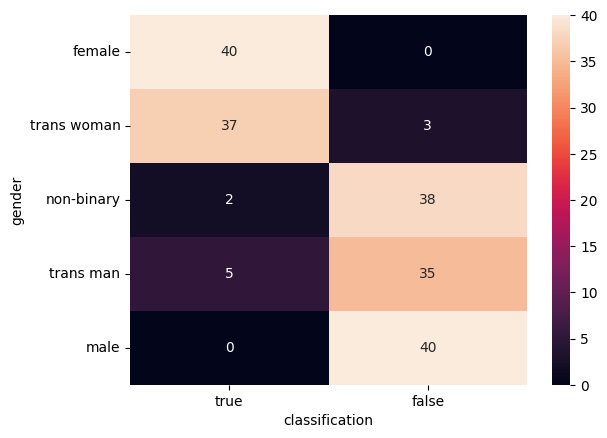

In [17]:
sn.heatmap(confusion_matrix(oed_results), annot=True)

<Axes: xlabel='classification', ylabel='woman'>

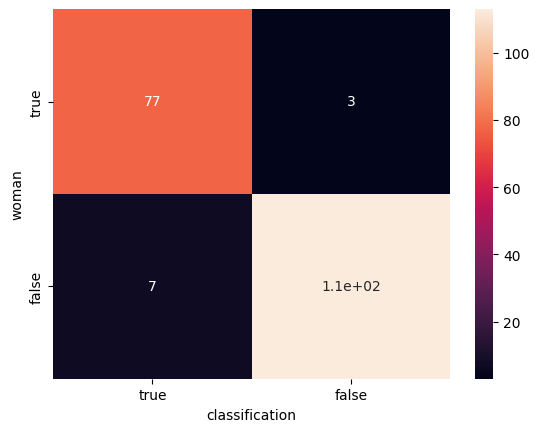

In [18]:
sn.heatmap(confusion_matrix_2(oed_results), annot=True)

In [19]:
oed_cm = pycm.ConfusionMatrix(oed_results["woman"].tolist(), oed_results["classification"].tolist(), digit=2, classes=['true', 'false'])
print(f'Accuracy: {oed_cm.overall_stat["Overall ACC"]:.2f}')
print(f'Scott\'s pi: {oed_cm.PI:.2f}')

Accuracy: 0.95
Scott's pi: 0.90


<Axes: xlabel='classification', ylabel='gender'>

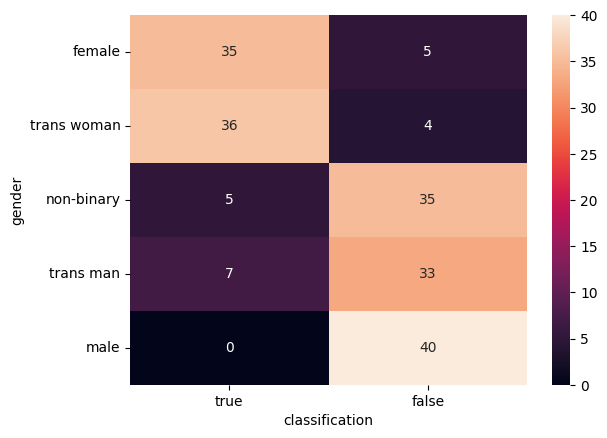

In [20]:
sn.heatmap(confusion_matrix(haslanger_results), annot=True)

<Axes: xlabel='classification', ylabel='woman'>

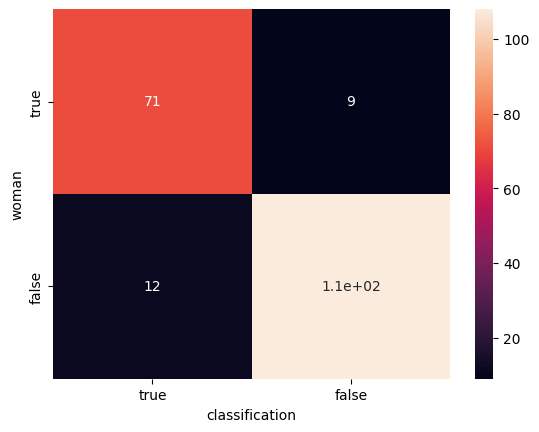

In [21]:
sn.heatmap(confusion_matrix_2(haslanger_results), annot=True)

In [22]:
haslanger_cm = pycm.ConfusionMatrix(haslanger_results["woman"].tolist(), haslanger_results["classification"].tolist(), digit=2, classes=['true', 'false'])
print(f'Accuracy: {haslanger_cm.overall_stat["Overall ACC"]:.2f}')
print(f'Scott\'s pi: {haslanger_cm.PI:.2f}')

Accuracy: 0.90
Scott's pi: 0.78


<Axes: xlabel='classification', ylabel='gender'>

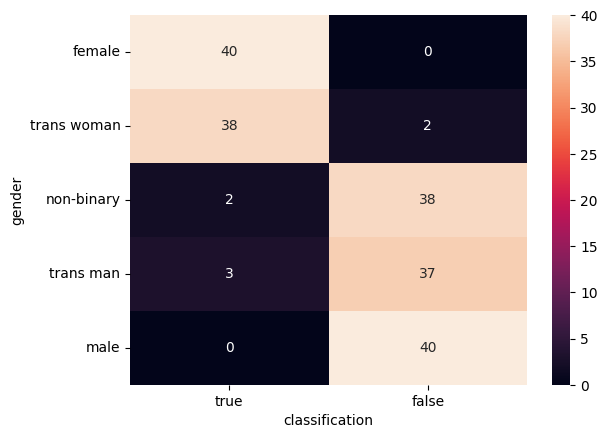

In [23]:
sn.heatmap(confusion_matrix(homosaurus_results), annot=True)

<Axes: xlabel='classification', ylabel='woman'>

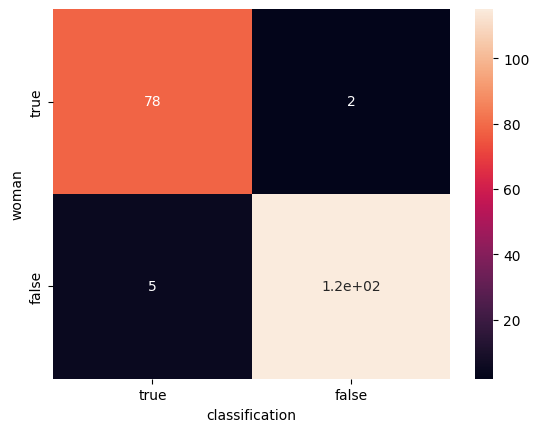

In [24]:
sn.heatmap(confusion_matrix_2(homosaurus_results), annot=True)

In [25]:
homosaurus_cm = pycm.ConfusionMatrix(homosaurus_results["woman"].tolist(), homosaurus_results["classification"].tolist(), digit=2, classes=['true', 'false'])
print(f'Accuracy: {homosaurus_cm.overall_stat["Overall ACC"]:.2f}')
print(f'Scott\'s pi: {homosaurus_cm.PI:.2f}')

Accuracy: 0.96
Scott's pi: 0.93


In [26]:
def evaluation_record(model, concept, data):
    return {
        "created": datetime.now().isoformat(),
        "model": {
            "name": cea.model_name,
            "temperature": cea.temperature,
        },
        "concept": concept.to_json(),
        "data": data.to_dict('records'),
    }

In [27]:
oed_evaluation_record = evaluation_record(cea, oed_woman, pd.concat([entities, oed_classifications], axis=1))
haslanger_evaluation_record = evaluation_record(cea, haslanger_woman, pd.concat([entities, haslanger_classifications], axis=1))
homosaurus_evaluation_record = evaluation_record(cea, homosaurus_woman, pd.concat([entities, homosaurus_classifications], axis=1))
json.dump(
    oed_evaluation_record, 
    open(f'data/{oed_evaluation_record["model"]["name"]}_{oed_evaluation_record["concept"]["id"]}_{oed_evaluation_record["created"]}.json', 'w')
)
json.dump(
    haslanger_evaluation_record, 
    open(f'data/{haslanger_evaluation_record["model"]["name"]}_{haslanger_evaluation_record["concept"]["id"]}_{haslanger_evaluation_record["created"]}.json', 'w')
)
json.dump(
    homosaurus_evaluation_record, 
    open(f'data/{homosaurus_evaluation_record["model"]["name"]}_{homosaurus_evaluation_record["concept"]["id"]}_{homosaurus_evaluation_record["created"]}.json', 'w')
)